In [644]:
import numpy as np
import pandas as pd
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [645]:
cchp = -6.25
cbb = 2.47
cgb = 2.775
CAPchp = 2135
CAPbb = 995
CAPgb = 4800

In [710]:
ntypes = 3
nperiods = 24
maxstart0 = 1
nbuildings = 8
#George fox, bowland tower, bowland south, bowland east, charles carter, 
#county main, great hall, library

generators = [1, 1, 3]
min_load = [750, 300, 1250]
max_load = [CAPchp, CAPbb, CAPgb]
base_cost = [0, 741, 3462.5]
per_mw_cost = [cchp, cbb, cgb]
startup_cost = [0, 1235, 10] 
base_carbon = [0, 0, 1250*0.215]
per_mw_carbon = [0, 0, 0.215]

UA = [2310, 946, 449, 1159, 1220, 2785, 3124, 2972]
vent = [7336, 2460, 3603, 1375, 4071, 9711, 11830, 10347]
w_cap = [4500000000, 22400000000, 2960000000, 904000000, 3340000000, 7980000000, 3890000000, 6800000000]
a_cap = [22312444 , 3678042, 6876095, 2869117, 13656518, 19549475, 36665614, 31350510]

#tout = [4, 3, 4, 4, 4, 5, 6, 6, 7, 8, 11, 12, 13, 13, 12, 12, 10, 9, 9, 8, 8, 7, 7, 7]
#tout = [4, 4, 4, 3, 2, 1, 2, 3, 6, 8, 12, 13, 14, 15, 16, 15, 14, 12, 9, 8, 7, 6, 5, 4]
#tout = [9, 9, 8, 9, 9, 9, 9, 9, 9, 10, 11, 11, 12, 12, 12, 12, 11, 11, 10, 10, 10, 9, 9, 9]

#tout = [3, 2, 3, 3, 3, 2, 3, 3, 2, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 2, 1]
#tout = [4, 5, 5, 6, 6, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 5, 4, 4, 5, 4, 4, 5, 5]
#tout = [0, 0, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 1, 1, 1]

#tout = [3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 5, 6, 6, 6, 6, 6, 5, 5, 4, 4, 4, 4, 4, 4]
#tout = [6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 2, 2, 1, 1]
tout = [1, 1, 1, 1, 0, 0, 1, 1, 2, 3, 5, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

req_tin = [15, 15, 15, 15, 15, 15, 15, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15]
#req_tin = [15, 15, 15, 15, 15, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15]
#req_tin = [15, 15, 15, 15, 15, 15, 15, 15, 15, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15, 15, 15]
#req_tin = [21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]

#req_tin = [15, 15, 15, 15, 15, 15, 15, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 15, 15, 15]
#req_tin = [15, 15, 15, 15, 15, 15, 15, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 15, 15, 15]

req_tin = [15, 15, 15, 15, 15, 16, 17, 19, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 15, 15, 15]

max_tin = [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]

In [711]:
toutk = [x+273.15 for x in tout]
req_tink = [x+273.15 for x in req_tin]
max_tink = [x+273.15 for x in max_tin]

In [712]:
model = gp.Model("HeatGeneration")

ngen = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="ngen")
nstart = model.addVars(ntypes, nperiods, vtype=GRB.INTEGER, name="nstart")
output = model.addVars(ntypes, nperiods, vtype=GRB.CONTINUOUS, name="genoutput")

storageout = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="storageout")
refill = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="refill")
storagelevel = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name="storagelevel")

Energyin = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="Energyin")
wallenergy = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="wallenergy")
airenergy = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name="airenergy")
tin = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name='tin')
twall = model.addVars(nbuildings, nperiods, vtype=GRB.CONTINUOUS, name='twall')
totalenergy = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name='totalenergy')
edtotalenergy = model.addVars(nperiods, vtype=GRB.CONTINUOUS, name='edtotalenergy')
airenergychange = model.addVars(nbuildings, nperiods, lb=-float('inf'), vtype=GRB.CONTINUOUS, name='airenergychange')
wallenergychange = model.addVars(nbuildings, nperiods, lb=-float('inf'), vtype=GRB.CONTINUOUS, name='wallenergychange')

In [713]:
edittingdemand = model.addConstrs(edtotalenergy[period] == 3*totalenergy[period] for period in range(nperiods))

In [714]:
wallenchange = model.addConstrs(wallenergychange[build, period] == ((UA[build]*(tin[build, period]-twall[build, period])
                                                                     +UA[build]*(toutk[period]-twall[build, period]))/1000)
                         for build in range(nbuildings) for period in range(nperiods))
airenchange = model.addConstrs(airenergychange[build, period] == ((UA[build]*(twall[build, period]-tin[build, period])
                                                                   +vent[build]*1.225*(toutk[period]-tin[build, period]))/1000)
                         for build in range(nbuildings) for period in range(nperiods))


In [715]:
ae = model.addConstrs(airenergy[build, period] == airenergy[build, period-1] + Energyin[build, period] 
                                  + airenergychange[build, period]
                                 for build in range(nbuildings) for period in range (1,nperiods))
we = model.addConstrs(wallenergy[build, period] == wallenergy[build, period-1] 
                                  + wallenergychange[build, period]
                                 for build in range(nbuildings) for period in range (1,nperiods))
ae0 = model.addConstrs(airenergy[build, 0] == airenergy[build, nperiods-1] + Energyin[build, 0] 
                                   + airenergychange[build, 0]
                                  for build in range(nbuildings))
we0 = model.addConstrs(wallenergy[build, 0] == wallenergy[build, nperiods-1]
                                   + wallenergychange[build, 0]
                                  for build in range(nbuildings))

In [716]:
mintempconstraint = model.addConstrs(tin[build, period] >= req_tink[period]
                                  for build in range(nbuildings) for period in range (nperiods))
maxtempconstraint = model.addConstrs(tin[build, period] <= max_tink[period]
                                  for build in range(nbuildings) for period in range (nperiods))

In [717]:
airbuildingtemp = model.addConstrs(tin[build, period] == airenergy[build, period]*3600000/(1.225*a_cap[build])
                               for build in range(nbuildings) for period in range(nperiods))
wallbuildingtemp = model.addConstrs(twall[build, period] == wallenergy[build, period]*3600000/(w_cap[build])
                               for build in range(nbuildings) for period in range(nperiods))

In [718]:
gen = model.addConstrs(ngen[type, period] <= generators[type]
                         for type in range(ntypes) for period in range(nperiods))

In [719]:
min_output = model.addConstrs((output[type, period] >= min_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

max_output = model.addConstrs((output[type, period] <= max_load[type] * ngen[type, period])
                              for type in range(ntypes) for period in range(nperiods))

In [720]:
total_demand = model.addConstrs(totalenergy[period] == gp.quicksum(Energyin[build, period] 
                            for build in range(nbuildings))
                               for period in range(nperiods))

In [721]:
meet_demand = model.addConstrs(gp.quicksum(output[type, period] for type in range(ntypes)) + 
                               storageout[period]
                               >= edtotalenergy[period] + refill[period]
                               for period in range(nperiods))

In [722]:
storage = model.addConstrs(storagelevel[period] == storagelevel[period-1] + refill[period] -
                             storageout[period]
                             for period in range(1,nperiods))

storage_max = model.addConstrs(storagelevel[period] <= 2300 for period in range(nperiods))

storage0 = model.addConstr(storagelevel[0] == storagelevel[nperiods-1] + refill[0] -
                             storageout[0])

In [723]:
startup0 = model.addConstrs((ngen[type,0] <= maxstart0 + nstart[type,0])
                            for type in range(ntypes))

startup = model.addConstrs((ngen[type,period] <= ngen[type,period-1] + nstart[type,period])
                           for type in range(ntypes) for period in range(1,nperiods))

In [724]:
active_money = gp.quicksum(base_cost[type]*ngen[type,period]
                    for type in range(ntypes) for period in range(nperiods))

per_mw_money = gp.quicksum(per_mw_cost[type]*(output[type,period] - min_load[type]*ngen[type,period])
                       for type in range(ntypes) for period in range(nperiods))

startup_obj_money = gp.quicksum(startup_cost[type]*nstart[type,period]
                         for type in range(ntypes) for period in range(nperiods))

model.setObjective(active_money + per_mw_money + startup_obj_money)

In [725]:
model.setParam(GRB.Param.Presolve, 0)
model.optimize()

Changed value of parameter Presolve to 0
   Prev: -1  Min: -1  Max: 2  Default: -1
Optimize a model with 1944 rows, 1680 columns and 4749 nonzeros
Variable types: 1536 continuous, 144 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-04, 5e+03]
  Objective range  [1e-13, 5e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+03]
Variable types: 1536 continuous, 144 integer (0 binary)

Root relaxation: objective -1.475457e+05, 753 iterations, 0.07 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -147545.69    0   17          - -147545.69      -     -    0s
     0     0 -147537.39    0   18          - -147537.39      -     -    0s
     0     0 -147537.39    0   14          - -147537.39      -     -    0s
     0     0 -147537.39    0   12          - -147537.39      -     -    0s
     0     2 -147537.39    0   11          - -147537.39  

In [305]:
model.computeIIS()

IIS runtime: 0.10 seconds


GurobiError: Cannot compute IIS on a feasible model

In [62]:
model.write('error2.ilp')

GurobiError: No IIS available for current model

In [726]:
rows = ["edtotalenergy"]
edtotalenergytable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for p in range(nperiods):
    edtotalenergytable.loc["edtotalenergy", p] = edtotalenergy[p].x
edtotalenergytable1 = edtotalenergytable.transpose()
edtotalenergytable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
edtotalenergy,2788.726866,2789.248304,2789.767125,2790.283343,2977.326773,3348.987282,3394.218318,3996.869288,3901.942655,3946.655146,...,3431.950575,3431.607025,3431.265196,3430.925077,3430.586657,3430.249926,3429.914874,1203.198356,2042.246794,2042.427694


In [727]:
rows = ["wallenergy" + str(b) for b in range(nbuildings)]
wallenergytable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        wallenergytable.loc["wallenergy"+str(b), p] = wallenergy[b,p].x
wallenergytable1 = wallenergytable.transpose()
wallenergytable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
wallenergy0,3.552162e+05,3.552023e+05,3.551885e+05,3.551747e+05,3.551586e+05,3.551449e+05,3.551358e+05,3.551314e+05,3.551316e+05,3.551364e+05,...,3.551899e+05,3.551991e+05,3.552083e+05,3.552174e+05,3.552265e+05,3.552356e+05,3.552446e+05,3.552398e+05,3.552350e+05,3.552302e+05
wallenergy1,1.768056e+06,1.768051e+06,1.768045e+06,1.768039e+06,1.768033e+06,1.768027e+06,1.768023e+06,1.768022e+06,1.768022e+06,1.768023e+06,...,1.768045e+06,1.768049e+06,1.768053e+06,1.768057e+06,1.768060e+06,1.768064e+06,1.768068e+06,1.768066e+06,1.768064e+06,1.768062e+06
wallenergy2,2.336401e+05,2.336374e+05,2.336347e+05,2.336320e+05,2.336289e+05,2.336262e+05,2.336244e+05,2.336236e+05,2.336236e+05,2.336245e+05,...,2.336348e+05,2.336366e+05,2.336384e+05,2.336402e+05,2.336420e+05,2.336438e+05,2.336456e+05,2.336446e+05,2.336437e+05,2.336428e+05
wallenergy3,7.136711e+04,7.136009e+04,7.135314e+04,7.134625e+04,7.133827e+04,7.133152e+04,7.132712e+04,7.132506e+04,7.132532e+04,7.132787e+04,...,7.135495e+04,7.135952e+04,7.136406e+04,7.136855e+04,7.137301e+04,7.137742e+04,7.138179e+04,7.137923e+04,7.137670e+04,7.137419e+04
wallenergy4,2.636433e+05,2.636360e+05,2.636287e+05,2.636214e+05,2.636129e+05,2.636056e+05,2.636008e+05,2.635984e+05,2.635985e+05,2.636010e+05,...,2.636292e+05,2.636341e+05,2.636389e+05,2.636438e+05,2.636486e+05,2.636534e+05,2.636582e+05,2.636557e+05,2.636532e+05,2.636507e+05
wallenergy5,6.299008e+05,6.298840e+05,6.298673e+05,6.298506e+05,6.298312e+05,6.298146e+05,6.298036e+05,6.297982e+05,6.297984e+05,6.298041e+05,...,6.298685e+05,6.298796e+05,6.298907e+05,6.299017e+05,6.299127e+05,6.299237e+05,6.299347e+05,6.299290e+05,6.299233e+05,6.299176e+05
wallenergy6,3.070782e+05,3.070593e+05,3.070406e+05,3.070219e+05,3.070003e+05,3.069819e+05,3.069698e+05,3.069640e+05,3.069644e+05,3.069711e+05,...,3.070437e+05,3.070561e+05,3.070684e+05,3.070806e+05,3.070928e+05,3.071050e+05,3.071170e+05,3.071104e+05,3.071037e+05,3.070972e+05
wallenergy7,5.367649e+05,5.367470e+05,5.367292e+05,5.367114e+05,5.366907e+05,5.366730e+05,5.366614e+05,5.366556e+05,5.366559e+05,5.366620e+05,...,5.367308e+05,5.367426e+05,5.367544e+05,5.367662e+05,5.367779e+05,5.367896e+05,5.368013e+05,5.367951e+05,5.367890e+05,5.367828e+05


In [728]:
rows = ["airenergy" + str(b) for b in range(nbuildings)]
airenergytable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        airenergytable.loc["airenergy"+str(b), p] = airenergy[b,p].x
airenergytable1 = airenergytable.transpose()
airenergytable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
airenergy0,2187.758376,2187.758376,2187.758376,2187.758376,2187.758376,2195.350805,2202.943234,2218.128092,2225.720521,2233.312949,...,2233.312949,2233.312949,2233.312949,2233.312949,2233.312949,2233.312949,2233.312949,2187.758376,2187.758376,2187.758376
airenergy1,360.635849,360.635849,360.635849,360.635849,360.635849,361.887405,363.138961,365.642073,366.893629,368.145185,...,368.145185,368.145185,368.145185,368.145185,368.145185,368.145185,368.145185,360.635849,360.635849,360.635849
airenergy2,674.208277,674.208277,674.208277,674.208277,674.208277,676.548060,678.887842,683.567407,685.907189,688.246971,...,688.246971,688.246971,688.246971,688.246971,688.246971,688.246971,688.246971,674.208277,674.208277,674.208277
airenergy3,281.319911,281.319911,281.319911,281.319911,281.319911,282.296207,283.272504,285.225098,286.201394,287.177691,...,287.177691,287.177691,287.177691,287.177691,287.177691,287.177691,287.177691,281.319911,281.319911,281.319911
airenergy4,1339.035815,1339.035815,1339.035815,1339.035815,1339.035815,1343.682825,1348.329835,1357.623854,1362.270863,1366.917873,...,1366.917873,1366.917873,1366.917873,1366.917873,1366.917873,1366.917873,1366.917873,1339.035815,1339.035815,1339.035815
airenergy5,1916.846388,1916.846388,1916.846388,1916.846388,1916.846388,1923.498640,1930.150892,1943.455395,1950.107647,1956.759899,...,1956.759899,1956.759899,1956.759899,1956.759899,1956.759899,1956.759899,1956.759899,1916.846388,1916.846388,1916.846388
airenergy6,3595.101646,3595.101646,3595.101646,3595.101646,3595.101646,3607.578140,3620.054633,3645.007621,3657.484114,3669.960608,...,3669.960608,3669.960608,3669.960608,3669.960608,3669.960608,3669.960608,3669.960608,3595.101646,3595.101646,3595.101646
airenergy7,3073.950162,3073.950162,3073.950162,3073.950162,3073.950162,3084.618044,3095.285926,3116.621690,3127.289572,3137.957454,...,3137.957454,3137.957454,3137.957454,3137.957454,3137.957454,3137.957454,3137.957454,3073.950162,3073.950162,3073.950162


In [729]:
rows = ["tin" + str(b) for b in range(nbuildings)]
tintable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        tintable.loc["tin"+str(b), p] = tin[b,p].x
tintable1 = tintable.transpose()
tintable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
tin0,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin1,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin2,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin3,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin4,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin5,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin6,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15
tin7,288.15,288.15,288.15,288.15,288.15,289.15,290.15,292.15,293.15,294.15,...,294.15,294.15,294.15,294.15,294.15,294.15,294.15,288.15,288.15,288.15


In [730]:
rows = ["Energyin" + str(b) for b in range(nbuildings)]
Energyintable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        Energyintable.loc["Energyin"+str(b), p] = Energyin[b,p].x
Energyintable1 = Energyintable.transpose()
Energyintable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Energyin0,134.999283,135.024997,135.050617,135.076142,144.092427,163.006778,165.333501,195.527285,190.244474,192.545588,...,166.881129,166.864133,166.847200,166.830328,166.813519,166.796772,166.780086,53.454808,99.018243,99.027073
Energyin1,45.971170,45.972033,45.972896,45.973759,48.988265,54.200183,55.146757,64.317600,64.012043,64.957754,...,57.675889,57.675314,57.674739,57.674164,57.673589,57.673015,57.672441,26.406394,33.916018,33.916306
Energyin2,63.584346,63.585819,63.587290,63.588760,68.004148,75.208072,75.658046,87.723663,85.832874,86.281377,...,75.108595,75.107615,75.106637,75.105659,75.104683,75.103708,75.102734,31.888486,45.927676,45.928171
Energyin3,28.153169,28.185558,28.217650,28.249449,29.970632,33.821475,35.000761,41.673307,41.854821,43.002042,...,38.532043,38.510914,38.489979,38.469234,38.448680,38.428314,38.408133,15.501910,21.371389,21.382981
Energyin4,74.677546,74.687199,74.696827,74.706429,79.704581,90.568114,91.794437,108.858503,105.431391,106.648089,...,91.990057,91.983661,91.977281,91.970919,91.964573,91.958244,91.951931,26.831327,54.716680,54.719967
Energyin5,177.639767,177.660818,177.681817,177.702764,189.623123,210.977182,213.775982,249.796969,245.929504,248.707311,...,218.182268,218.168315,218.154397,218.140514,218.126666,218.112853,218.099074,90.106910,130.027601,130.034762
Energyin6,215.269692,215.324208,215.378411,215.432302,229.986614,260.132079,263.291035,311.015824,301.662070,304.766856,...,263.097036,263.061180,263.025529,262.990084,262.954842,262.919803,262.884965,82.350745,157.228839,157.247860
Energyin7,189.280651,189.308803,189.336867,189.364843,202.072467,228.415210,231.405586,273.376613,265.680375,268.642697,...,232.516509,232.497877,232.479304,232.460790,232.442333,232.423935,232.405594,74.525538,138.542485,138.552110


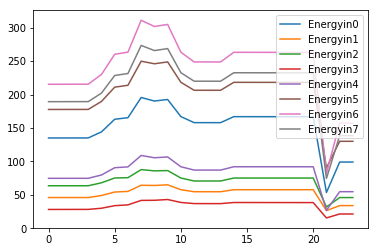

In [731]:
sns.lineplot(data = Energyintable1, dashes = False)

In [732]:
rows = ["airenergychange" + str(b) for b in range(nbuildings)]
airenergychangetable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        airenergychangetable.loc["airenergychange"+str(b), p] = airenergychange[b,p].x
airenergychangetable1 = airenergychangetable.transpose()
airenergychangetable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
airenergychange0,-134.999283,-135.024997,-135.050617,-135.076142,-144.092427,-155.414349,-157.741072,-180.342427,-182.652045,-184.953159,...,-166.881129,-166.864133,-166.847200,-166.830328,-166.813519,-166.796772,-166.780086,-99.009381,-99.018243,-99.027073
airenergychange1,-45.971170,-45.972033,-45.972896,-45.973759,-48.988265,-52.948627,-53.895202,-61.814488,-62.760487,-63.706198,...,-57.675889,-57.675314,-57.674739,-57.674164,-57.673589,-57.673015,-57.672441,-33.915729,-33.916018,-33.916306
airenergychange2,-63.584346,-63.585819,-63.587290,-63.588760,-68.004148,-72.868289,-73.318264,-83.044098,-83.493091,-83.941595,...,-75.108595,-75.107615,-75.106637,-75.105659,-75.104683,-75.103708,-75.102734,-45.927180,-45.927676,-45.928171
airenergychange3,-28.153169,-28.185558,-28.217650,-28.249449,-29.970632,-32.845179,-34.024464,-39.720713,-40.878524,-42.025746,...,-38.532043,-38.510914,-38.489979,-38.469234,-38.448680,-38.428314,-38.408133,-21.359690,-21.371389,-21.382981
airenergychange4,-74.677546,-74.687199,-74.696827,-74.706429,-79.704581,-85.921104,-87.147427,-99.564483,-100.784381,-102.001079,...,-91.990057,-91.983661,-91.977281,-91.970919,-91.964573,-91.958244,-91.951931,-54.713385,-54.716680,-54.719967
airenergychange5,-177.639767,-177.660818,-177.681817,-177.702764,-189.623123,-204.324930,-207.123730,-236.492465,-239.277252,-242.055059,...,-218.182268,-218.168315,-218.154397,-218.140514,-218.126666,-218.112853,-218.099074,-130.020421,-130.027601,-130.034762
airenergychange6,-215.269692,-215.324208,-215.378411,-215.432302,-229.986614,-247.655586,-250.814542,-286.062837,-289.185576,-292.290363,...,-263.097036,-263.061180,-263.025529,-262.990084,-262.954842,-262.919803,-262.884965,-157.209707,-157.228839,-157.247860
airenergychange7,-189.280651,-189.308803,-189.336867,-189.364843,-202.072467,-217.747328,-220.737704,-252.040849,-255.012493,-257.974815,...,-232.516509,-232.497877,-232.479304,-232.460790,-232.442333,-232.423935,-232.405594,-138.532829,-138.542485,-138.552110


In [733]:
rows = ["wallenergychange" + str(b) for b in range(nbuildings)]
wallenergychangetable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        wallenergychangetable.loc["wallenergychange"+str(b), p] = wallenergychange[b,p].x
wallenergychangetable1 = wallenergychangetable.transpose()
wallenergychangetable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
wallenergychange0,-13.966235,-13.914806,-13.863566,-13.812515,-16.063146,-13.702501,-9.049056,-4.412746,0.206490,4.808717,...,9.231059,9.197066,9.163199,9.129457,9.095838,9.062344,9.028973,-4.813237,-4.795513,-4.777854
wallenergychange1,-5.679660,-5.677934,-5.676208,-5.674482,-6.618470,-5.670746,-3.777597,-1.885024,0.006974,1.898397,...,3.783777,3.782627,3.781477,3.780328,3.779179,3.778030,3.776881,-1.898541,-1.897964,-1.897387
wallenergychange2,-2.700208,-2.697262,-2.694320,-2.691380,-3.136954,-2.685022,-1.785072,-0.886104,0.011883,0.908890,...,1.795589,1.793630,1.791673,1.789719,1.787766,1.785816,1.783867,-0.909140,-0.908148,-0.907157
wallenergychange3,-7.082162,-7.017385,-6.953200,-6.889602,-7.974985,-6.753643,-4.395072,-2.058074,0.257549,2.551991,...,4.620086,4.577828,4.535957,4.494469,4.453360,4.412627,4.372267,-2.558119,-2.534721,-2.511537
wallenergychange4,-7.360208,-7.340902,-7.321647,-7.302442,-8.500087,-7.260991,-4.808346,-2.362133,0.077663,2.511059,...,4.876914,4.864122,4.851363,4.838638,4.825946,4.813287,4.800662,-2.512730,-2.506139,-2.499565
wallenergychange5,-16.797767,-16.755663,-16.713666,-16.671773,-19.408005,-16.581340,-10.983740,-5.400170,0.169404,5.725018,...,11.133335,11.105430,11.077594,11.049828,11.022132,10.994505,10.966948,-5.728657,-5.714299,-5.699976
wallenergychange6,-18.965617,-18.856584,-18.748178,-18.640395,-21.639272,-18.408829,-12.090916,-5.809326,0.436152,6.645725,...,12.474072,12.402359,12.331058,12.260167,12.189684,12.119606,12.049931,-6.655585,-6.617323,-6.579280
wallenergychange7,-17.948799,-17.892494,-17.836367,-17.780415,-20.687315,-17.659743,-11.678992,-5.717001,0.226287,6.150931,...,11.878617,11.841355,11.804209,11.767180,11.730267,11.693469,11.656787,-6.155841,-6.136531,-6.117281


In [734]:
rows = ["airenergychange" + str(b) for b in range(nbuildings)]
airchangetable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for b in range(nbuildings):
    for p in range(nperiods):
        airchangetable.loc["airenergychange"+str(b), p] = airenergychange[b,p].x
airchangetable1 = airchangetable.transpose()
airchangetable

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
airenergychange0,-134.999283,-135.024997,-135.050617,-135.076142,-144.092427,-155.414349,-157.741072,-180.342427,-182.652045,-184.953159,...,-166.881129,-166.864133,-166.847200,-166.830328,-166.813519,-166.796772,-166.780086,-99.009381,-99.018243,-99.027073
airenergychange1,-45.971170,-45.972033,-45.972896,-45.973759,-48.988265,-52.948627,-53.895202,-61.814488,-62.760487,-63.706198,...,-57.675889,-57.675314,-57.674739,-57.674164,-57.673589,-57.673015,-57.672441,-33.915729,-33.916018,-33.916306
airenergychange2,-63.584346,-63.585819,-63.587290,-63.588760,-68.004148,-72.868289,-73.318264,-83.044098,-83.493091,-83.941595,...,-75.108595,-75.107615,-75.106637,-75.105659,-75.104683,-75.103708,-75.102734,-45.927180,-45.927676,-45.928171
airenergychange3,-28.153169,-28.185558,-28.217650,-28.249449,-29.970632,-32.845179,-34.024464,-39.720713,-40.878524,-42.025746,...,-38.532043,-38.510914,-38.489979,-38.469234,-38.448680,-38.428314,-38.408133,-21.359690,-21.371389,-21.382981
airenergychange4,-74.677546,-74.687199,-74.696827,-74.706429,-79.704581,-85.921104,-87.147427,-99.564483,-100.784381,-102.001079,...,-91.990057,-91.983661,-91.977281,-91.970919,-91.964573,-91.958244,-91.951931,-54.713385,-54.716680,-54.719967
airenergychange5,-177.639767,-177.660818,-177.681817,-177.702764,-189.623123,-204.324930,-207.123730,-236.492465,-239.277252,-242.055059,...,-218.182268,-218.168315,-218.154397,-218.140514,-218.126666,-218.112853,-218.099074,-130.020421,-130.027601,-130.034762
airenergychange6,-215.269692,-215.324208,-215.378411,-215.432302,-229.986614,-247.655586,-250.814542,-286.062837,-289.185576,-292.290363,...,-263.097036,-263.061180,-263.025529,-262.990084,-262.954842,-262.919803,-262.884965,-157.209707,-157.228839,-157.247860
airenergychange7,-189.280651,-189.308803,-189.336867,-189.364843,-202.072467,-217.747328,-220.737704,-252.040849,-255.012493,-257.974815,...,-232.516509,-232.497877,-232.479304,-232.460790,-232.442333,-232.423935,-232.405594,-138.532829,-138.542485,-138.552110


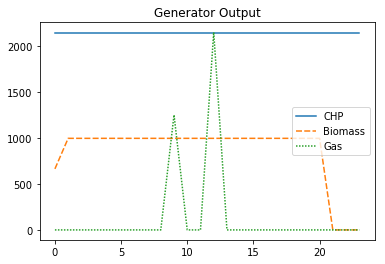

In [735]:
rows = ["Generators" + str(t) for t in range(ntypes)]
generatorsouttable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for t in range(ntypes):
    for p in range(nperiods):
        generatorsouttable.loc["Generators" + str(t), p] = output[t,p].x
generatorsouttable1 = generatorsouttable.transpose()
output = sns.lineplot(data = generatorsouttable1)
output.legend(["CHP","Biomass","Gas"])
output.set_title("Generator Output")
plt.savefig("scen3part4output.png")

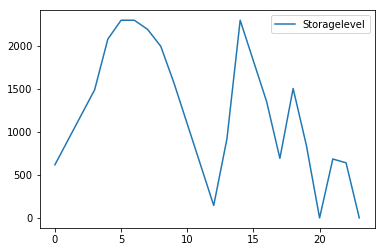

In [706]:
rows = ["Storagelevel"]
storagetable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)


for p in range(nperiods):
        storagetable.loc["Storagelevel", p] = storagelevel[p].x
storagetable1 = storagetable.transpose()
storagetable
sns.lineplot(data = storagetable1, dashes = False)
plt.savefig('scen3part4storage.png')

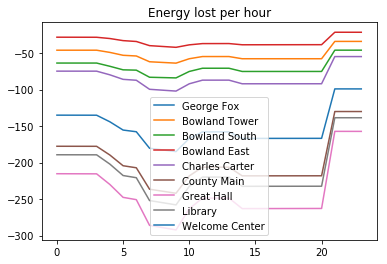

In [736]:
output = sns.lineplot(data = airenergychangetable1, dashes = False)
output.legend(["George Fox", "Bowland Tower","Bowland South","Bowland East","Charles Carter","County Main","Great Hall","Library","Welcome Center"])
output.set_title("Energy lost per hour")
plt.savefig('newout3.png')

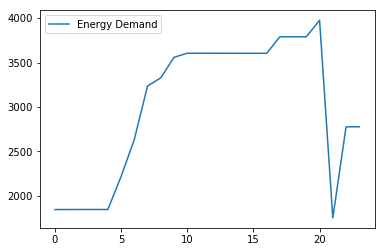

In [708]:
output = sns.lineplot(data = edtotalenergytable1,)
output.legend(["Energy Demand"])
plt.savefig('scen3part4energydemand.png')

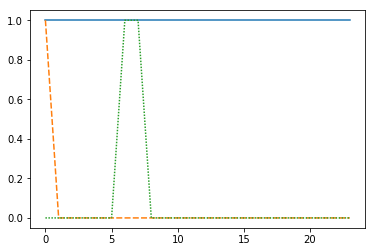

In [675]:
rows = ["Generators" + str(t) for t in range(ntypes)]
generatorstable = pd.DataFrame(columns=range(nperiods), index=rows, data=0.0)

for t in range(ntypes):
    for p in range(nperiods):
        generatorstable.loc["Generators"+str(t), p] = ngen[t,p].x
generatorstable1 = generatorstable.transpose()
generatorstable
sns.lineplot(data = generatorstable1, legend = False)

In [676]:
tintablec = [x-273.15 for x in tintable1]

TypeError: unsupported operand type(s) for -: 'str' and 'float'

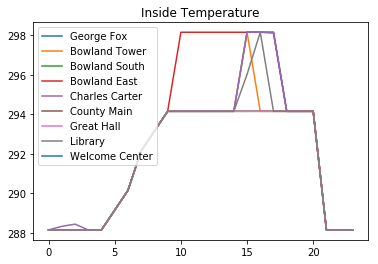

In [679]:
output = sns.lineplot(data = tintable1, dashes = False)
output.legend(["George Fox", "Bowland Tower","Bowland South","Bowland East","Charles Carter","County Main","Great Hall","Library","Welcome Center"])
output.set_title("Inside Temperature")
plt.savefig('newout1.png')